## Problem Definition

My client runs a drop shipping website and sells other supplier products on his website. one supplier sent him a [PDF file](files/products-data.pdf) that contains all of his products data and a folder that contains [products images](hq_unordered) in a full resolution, the PDF contains each product thumbnail image, product name, and product price. The problem is the high-quality images are not in the same order as it appears on the PDF file, so there has to be a solution to sort the images the exact sorting as it appears on the PDF to sync the images perfectly with each relevant product info.

<img src="files/prods-info.png" width="800">


## Solution

The first thing to do is extracting the thumbnail images from the PDF file. The easiest way is to save the PDF file as html page, and all the images will be saved in one folder. The problem of this method is for some reason it saves two versions of each image, one version is the same resolution as it appears in the PDF file and the other version is a compressed image with a very low resolution, but the good thing about this method is that it saves the images in the same ordering as on the PDF file.
![](files/imgs-html-output.png)


In [2]:
import numpy as np
import os
import cv2
from matplotlib import pylab as plt
import re
import shutil
from tqdm import tqdm
%matplotlib notebook
%config Completer.use_jedi = False

The first step is cleaning the duplicated images, every two consecutive images on the thumbnail directory should be compared and the compressed version should be ignored.

In [3]:
THUMP_IMGS_PATH = 'thumpnail_imgs'
FULL_RES_UNORDERED_IMGS_PATH = 'hq_unordered'
thump_imgs_names = os.listdir(THUMP_IMGS_PATH)

In [71]:
print(thump_imgs_names[90:100])

['image094.jpg', 'image095.jpg', 'image096.jpg', 'image097.jpg', 'image098.jpg', 'image099.jpg', 'image100.jpg', 'image1000.jpg', 'image1001.jpg', 'image1002.jpg']


After listing images names, it shows a name ordering issue, ```image1000.jpg``` comes after ```image100.jpg``` and this ordering should be edited to correctly compare every two consecutive images. So, images names should be renamed and image sequence number should be represented in 4 digits instead of 3 to be right sorted.
To rename the images regular expression is used to add extra 0 when the image sequence number consists of 3 digits.

In [72]:
def rename_imgs():
    thump_imgs_names_renamed = []
    for img_name in thump_imgs_names:
        img_name = re.sub(r'(image)([\d]{3}[.])', r'image0\2', img_name)
        thump_imgs_names_renamed.append(img_name)
    return thump_imgs_names_renamed

In [73]:
renamed_imgs_names = rename_imgs()
print(imgs_names[90:100])

['image0094.jpg', 'image0095.jpg', 'image0096.jpg', 'image0097.jpg', 'image0098.jpg', 'image0099.jpg', 'image0100.jpg', 'image1000.jpg', 'image1001.jpg', 'image1002.jpg']


Images names are correctly edited. the images are copied to a new directory with the correct names.

In [74]:
RENAMED_THUMP_IMGS_PATH = 'renamed_thumpnail_imgs'
for i in range(len(thump_imgs_names)):
    src_img_path = os.path.join(THUMP_IMGS_PATH, thump_imgs_names[i])
    target_img_path = os.path.join(RENAMED_THUMP_IMGS_PATH, renamed_imgs_names[i])
    shutil.copy(src_img_path, target_img_path)

Now it is the time to clean the duplicated images. ```image_diff``` function is implemented to compare between two images by subtraction, the parameter ```HW``` is for passing the height and width as a tuple to resize the images before subtraction, if it is not set the larger resolution image is resized to the resolution of the lower resolution image.
```clean_duplicated_imgs``` function is defined to pass each two consecutive images and explicitly pass the height and width to a small resolution (90, 90) to speed up the process and returns the list of the calculated results of the subtraction.

In [8]:
renamed_imgs_names = os.listdir(RENAMED_THUMP_IMGS_PATH)

def image_diff(img1, img2, HW=None):
    if HW == None:
        H1, W1, _ = img1.shape
        H2, W2, _ = img2.shape
        if H1 > H2:
            WH = (W2, H2)
            img1 = cv2.resize(img1, WH)
        else:
            WH = (W1, H1)
            img2 = cv2.resize(img2, WH)
    else:
        WH = (HW[1], HW[0])
        img1 = cv2.resize(img1, WH)
        img2 = cv2.resize(img2, WH)

    img1 = cv2.GaussianBlur(img1, (11, 11), 0)
    img2 = cv2.GaussianBlur(img2, (11, 11), 0)

    img1 = img1.astype(np.int16)
    img2 = img2.astype(np.int16)

    diff = np.subtract(img1, img2)
    abs_diff = np.abs(diff)
    sum_abs_diff = np.sum(abs_diff)

    return sum_abs_diff / (WH[0] * WH[1])


def clean_duplicated_imgs():
    error_list = []

    img_indx = 0
    for i in range(int(len(thump_imgs_names) / 2)):
        img1_name = renamed_imgs_names[img_indx]
        img2_name = renamed_imgs_names[img_indx + 1]
        img1 = cv2.imread(os.path.join(RENAMED_THUMP_IMGS_PATH, img1_name))
        img2 = cv2.imread(os.path.join(RENAMED_THUMP_IMGS_PATH, img2_name))
        error = image_diff(img1, img2, (90, 90))
        error_list.append(error)
        img_indx += 2

    return error_list

In [9]:
error_list = clean_duplicated_imgs()

```error_list``` is plotted to better see the result values of the subtraction and decide whether they are reasonable values or not.

<IPython.core.display.Javascript object>


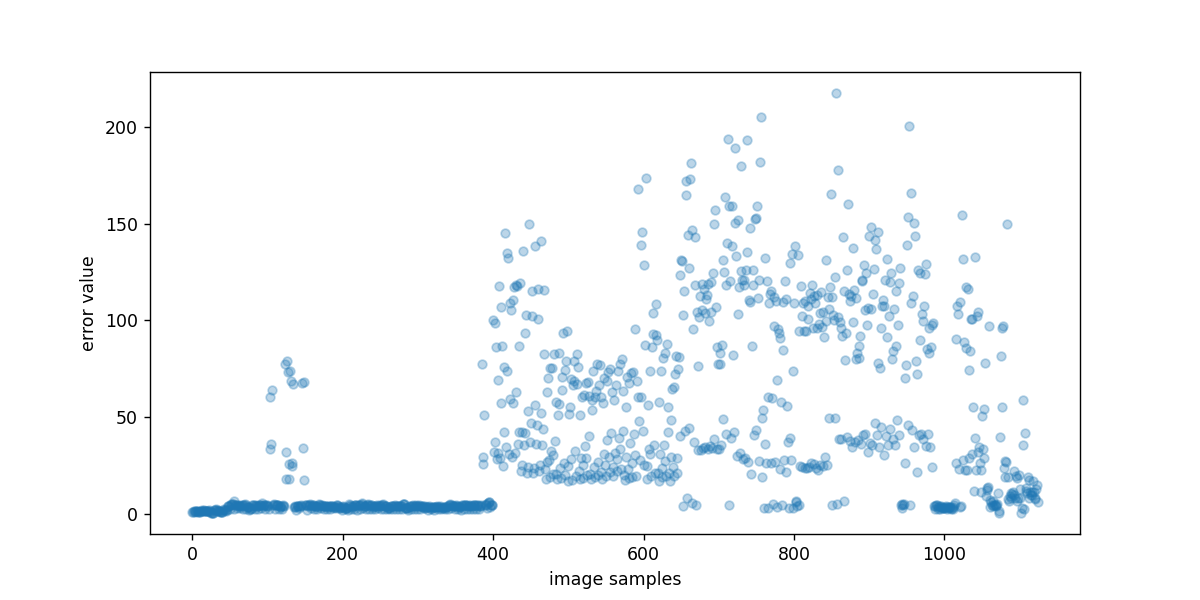

In [11]:
plt.figure(figsize=plt.figaspect(0.5))
plt.scatter(np.arange(len(error_list)),
            error_list,
            alpha=0.3,
            s=25)
plt.xlabel('image samples')
_ = plt.ylabel('error value')

From the plot it is obvious that the first miss sequencing happens after about 100 subtraction operation, from manual checking it seems that not all images are duplicated. The function should be modified to consider that not every image has a duplicate.
![missequencing](files/missequencing.png)

Reasonable error value should be less than 13 otherwise the image is considered to has no duplicate.


In [12]:
def get_heigher_res_img(img1_name, img2_name, path):
    im1 = cv2.imread(os.path.join(path, img1_name))
    im2 = cv2.imread(os.path.join(path, img2_name))

    res1 = im1.shape[0] * im1.shape[1]
    res2 = im2.shape[0] * im2.shape[1]

    if res1 > res2:
        return img1_name
    else:
        return img2_name

def clean_duplicated_imgs():
    error_thresh = 13
    
    single_imgs_indx = []
    single_imgs_error = []
    duplicate_imgs_error = []
    duplicate_imgs_indx = []
    
    unique_imgs = []

    img_indx = 0
    while img_indx < len(thump_imgs_names) - 1:
        img1_name = renamed_imgs_names[img_indx]
        img2_name = renamed_imgs_names[img_indx + 1]
        img1 = cv2.imread(os.path.join(RENAMED_THUMP_IMGS_PATH, img1_name))
        img2 = cv2.imread(os.path.join(RENAMED_THUMP_IMGS_PATH, img2_name))
        error = image_diff(img1, img2, (90, 90))

        if error > error_thresh:
            # (images are different) image has no duplicate
            single_imgs_indx.append(img_indx)
            single_imgs_error.append(error)
            unique_imgs.append(img1_name)
            img_indx += 1
        else:
            # identical images, keep only the higher res img
            duplicate_imgs_indx.append(img_indx)
            duplicate_imgs_error.append(error)
            unique_imgs.append(get_heigher_res_img(img1_name, img2_name, RENAMED_THUMP_IMGS_PATH))
            img_indx += 2

    errors = {'single_imgs_indx': single_imgs_indx,
             'single_imgs_error': single_imgs_error,
             'duplicate_imgs_indx': duplicate_imgs_indx,
             'duplicate_imgs_error': duplicate_imgs_error
             }
    return unique_imgs, errors

In [13]:
unique_imgs, errors = clean_duplicated_imgs()

<IPython.core.display.Javascript object>


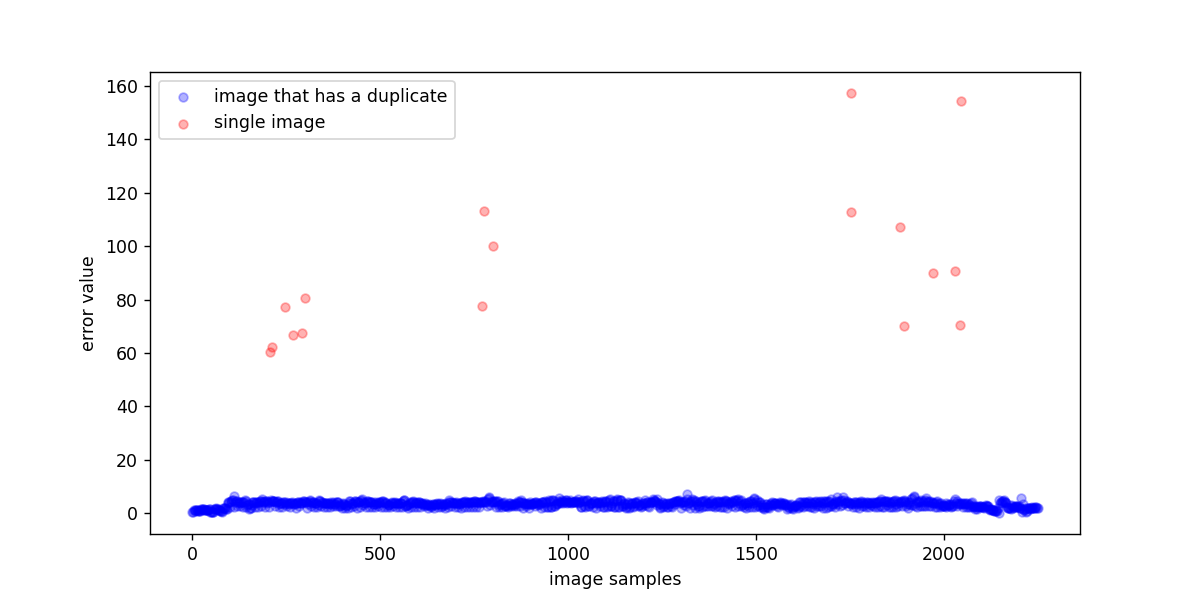

In [14]:
plt.figure(figsize=plt.figaspect(0.5))
plt.scatter(errors['duplicate_imgs_indx'],
            errors['duplicate_imgs_error'],
            alpha=0.3,
            s=25,
            c='blue')
plt.scatter(errors['single_imgs_indx'],
            errors['single_imgs_error'],
            alpha=0.3,
            s=25,
            c='red')
plt.legend(['image that has a duplicate', 'single image'])
plt.xlabel('image samples')
_ = plt.ylabel('error value')

The plot looks acceptable, and all the red dots are images that have no duplicates. Now the unique images could be copied to a new directory.

In [88]:
CLEANED_THUMP_IMGS_PATH = 'cleaned_thumpnail_imgs'
for img in unique_imgs:
    src_path = os.path.join(RENAMED_THUMP_IMGS_PATH, img)
    dst_path = os.path.join(CLEANED_THUMP_IMGS_PATH, img)
    shutil.copy(src_path, dst_path)

After the only unique images are copied to the new directory ```cleaned_thumpnail_imgs``` it is time to match each thumbnail image with the respective high resolution image. After manual inspection for some images an extra white borders are found.

<img src="files/different-object-size.jpg" width="600">

For these images simple subtraction would not work because the pixels would not match perfectly. one way to deal with this problem is to crop both images in a way that fits the objects on the image perfectly without any extra borders.

In [5]:
def crop_object(img):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_grey = cv2.GaussianBlur(img_grey, (7, 7), 0)
    img_grey = cv2.threshold(img_grey, 250, 255, cv2.THRESH_BINARY_INV)[1]
    img_grey = cv2.morphologyEx(img_grey, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11)))
    detected_objects = cv2.findContours(img_grey, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)[0]

    min_x = 65535
    max_x = 0
    min_y = 65535
    max_y = 0
    for obj in detected_objects:
        # crop a box contains all contours
        x, y, w, h = cv2.boundingRect(obj)
        if x < min_x:
            min_x = x
        if x + w > max_x:
            max_x = x + w

        if y < min_y:
            min_y = y
        if y + h > max_y:
            max_y = y + h
    cropped_obj = img[min_y:max_y, min_x:max_x, :]
    return cropped_obj

```search_for_heigher_res``` function tries to match one thumbnail image with every high resolution image and returns the name of the high resolution image that has the minimum error value. If ```crop_objects``` parameter is set to True; both images are cropped with ```crop_object``` function before subtraction.

In [6]:
def search_for_heigher_res(img, hq_imgs_list, crop_objects=False):
    low_res_img = cv2.imread(os.path.join(CLEANED_THUMP_IMGS_PATH, img))
    if crop_objects:
        low_res_img = crop_object(low_res_img)
    min_error = float('inf')
    for hq_img_name in hq_imgs_list:
        #hq_img = cv2.imread(os.path.join(FULL_RES_UNORDERED_IMGS_PATH, hq_img_name))
        im_path = os.path.join(FULL_RES_UNORDERED_IMGS_PATH, hq_img_name)
        hq_img = cv2.imdecode(np.fromfile(im_path, np.uint8), cv2.IMREAD_UNCHANGED)
        if crop_objects:
            hq_img = crop_object(hq_img)
        diff_error = image_diff(low_res_img, hq_img, HW=(150, 150))
        if diff_error < min_error:
            min_error = diff_error
            matched_img = hq_img_name
        
    return matched_img, min_error

This part uses the previous functions to search and match each thumbnail image with a high resolution image. a threshold with a value 15 is defined, if the thumbnail image has a minimum error larger than that threshold; the same process of matching would done but with cropping, if the minimum error is still larger than the threshold; the thumbnail image is considered missing and has no match for a high resolution image. During this process I kept track of all matched thumbnail images, number of matched thumbnail images after cropping, and matching error values.

In [7]:
CLEANED_THUMP_IMGS_PATH = 'cleaned_thumpnail_imgs'
cleaned_thump_imgs_names = os.listdir(CLEANED_THUMP_IMGS_PATH)
full_res_imgs_names = os.listdir(FULL_RES_UNORDERED_IMGS_PATH)
OUTPUT_PATH = 'output_imgs'
matched_imgs_after_crop = 0
error_list = []
matched_imgs = []
matching_thresh = 15

for img in tqdm(cleaned_thump_imgs_names):
    heigh_res_img, error = search_for_heigher_res(img, full_res_imgs_names)
    crop_obj = False
    
    if error > matching_thresh:
        # crop the object and search for heigher res match image
        crop_obj = True
        heigh_res_img, error = search_for_heigher_res(img, full_res_imgs_names, crop_objects=crop_obj)

    if error < matching_thresh:
        shutil.copy(os.path.join(FULL_RES_UNORDERED_IMGS_PATH, heigh_res_img), os.path.join(OUTPUT_PATH, img))
        matched_imgs.append(heigh_res_img)
        if crop_obj:
            matched_imgs_after_crop += 1
        
    else:
        shutil.copy('files/missing.jpg', os.path.join(OUTPUT_PATH, img))

    error_list.append(error)

for img in full_res_imgs_names:
    if img not in matched_imgs:
        shutil.copy(os.path.join(FULL_RES_UNORDERED_IMGS_PATH, img), os.path.join('remaining_unmatched', img))

100%|████████████████████████████████████████████████████████████████████████████| 1134/1134 [2:45:31<00:00,  8.76s/it]


After matching all thumbnail images I printed here some statistics to get an idea of how well the code works and find out how many thumbnail images are not matched with a high resolution image.

In [8]:
not_matched_imgs_zip = [(idx, error) for idx, error in enumerate(error_list) if error > matching_thresh]
not_matched_imgs_idx, not_matched_imgs_error = zip(*not_matched_imgs_zip)

matched_imgs_zip = [(idx, error) for idx, error in enumerate(error_list) if error < matching_thresh]
matched_imgs_idx, matched_imgs_error = zip(*matched_imgs_zip)

num_matched_imgs = len(matched_imgs_idx)
num_umatched_imgs = len(not_matched_imgs_idx)

print('# matched images: ' + str(num_matched_imgs))
print('# matched images after cropping: ' + str(matched_imgs_after_crop))
print('# unmatched images: ' + str(num_umatched_imgs))
print('-----------------------')
print('matching rate: %' + "{:.2f}".format((num_matched_imgs / (num_matched_imgs + num_umatched_imgs)) * 100))

# matched images: 910
# matched images after cropping: 15
# unmatched images: 224
-----------------------
matching rate: %80.25


As it shows there are 224 thumbnail images that did not match with a high resolution image, I need to plot the error values to get an idea of the missing images.

<IPython.core.display.Javascript object>


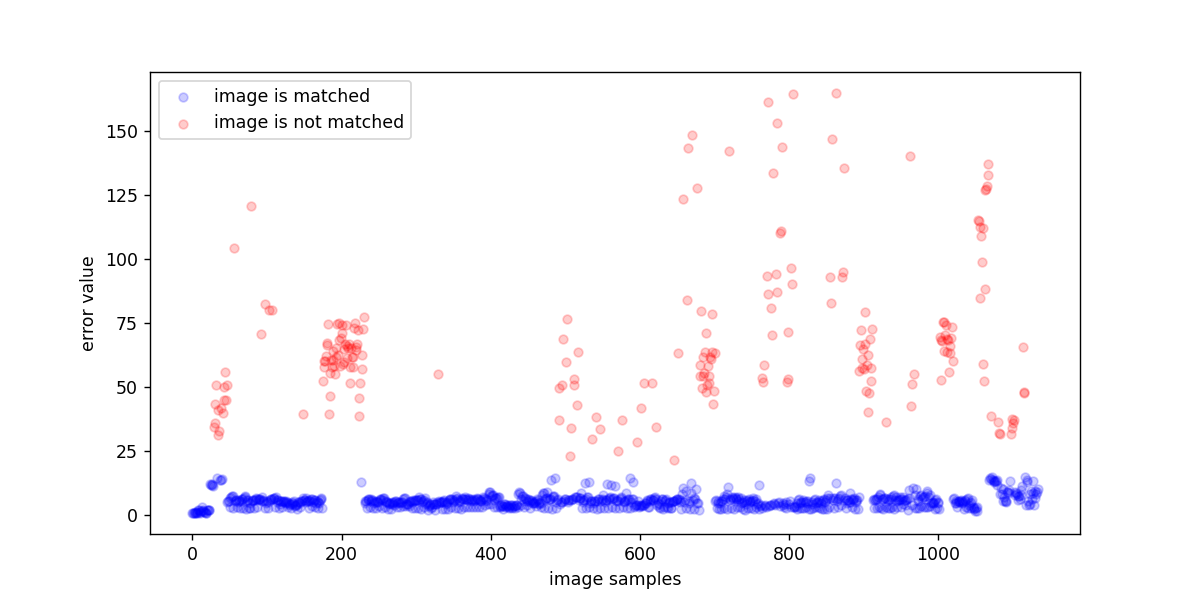

In [9]:
plt.figure(figsize=plt.figaspect(0.5))
plt.scatter(matched_imgs_idx,
            matched_imgs_error,
            alpha=0.2,
            s=25, c='blue')
plt.scatter(not_matched_imgs_idx,
            not_matched_imgs_error,
            alpha=0.2,
            s=25, c='red')
plt.legend(['image is matched', 'image is not matched'])
plt.xlabel('image samples')
plt.ylabel('error value')
plt.show()

From the plot and after manual inspection I found out that most of these images are actually missing and the supplier folder does not contain a high resolution image for all thumbnail images on the PDF file. Finally, I delivered the sorted images to my client and a placeholder image was placed for all the missing images to preserve image sequencing as on the PDF file and to define the missing images to my client so he could get back to the supplier and ask him for the missing images.